---
title: Replication Study
author: Otis Milliken
date: '2024-03-3'
description: "Blog Post for CS0451"
format: html
---

# Abstract 


In this blog post, I followed along with the study by Obermeyer, Ziad, Brian Powers, Christine Vogeli, and Sendhil Mullainathan (2019) called “Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations.” Essentially this blog posts steps through their methodology to understand how they got to the conclusions that they did. I found that there existed a black and white patient divide in the correlation between the mean number of chronic illness and risk percentile. I also found that there existed a disportionate cost of black patients compared to white patients.

In [190]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df["risk_percentile"] = (df["risk_score_t"].rank(pct=True) * 100).round()


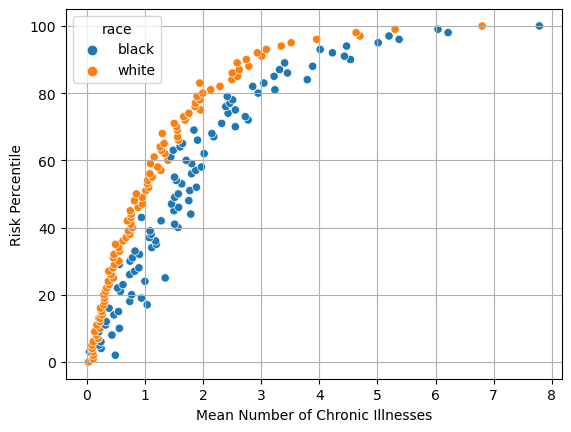

In [191]:
from matplotlib import pyplot as plt
import seaborn as sns

chart = df.groupby(["risk_percentile", "race"]).aggregate({"gagne_sum_t" : "mean"}).reset_index()

sns.scatterplot(data=chart, x="gagne_sum_t", y="risk_percentile", hue="race")
plt.xlabel("Mean Number of Chronic Illnesses")
plt.ylabel("Risk Percentile")
plt.grid(True)

## Explaining Chart
The chart shows the White patients on average have to have less chronic illnesses to have higher risk. This means that white patients are more likely to be referred to treatment (high risk treatment) than black patients. For example, a white patient with a risk percentile of 60 needs on average around 1.1 chronic illnesses while a black patient would need to have around 1.8-1.9 chronic illness to be in that same risk percentile.


[Text(0.5, 0, 'Chronic Of Illnesses'), Text(0, 0.5, 'Medical Cost'), None]

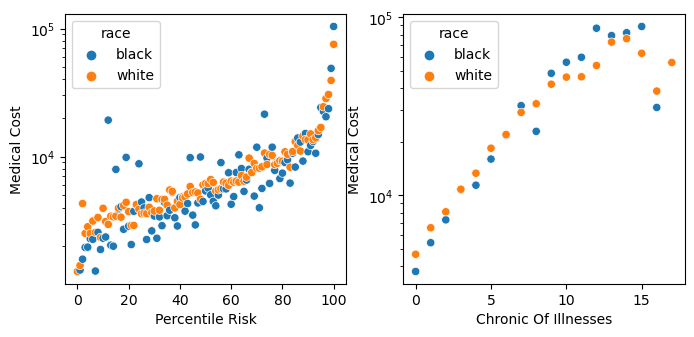

In [260]:
chart2 = df.groupby(["risk_percentile", "race"]).aggregate({"cost_t" : "mean"}).reset_index()
fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

sns.scatterplot(data=chart2, x="risk_percentile", y="cost_t", hue="race", ax=ax[0])
ax[0].set(xlabel ="Percentile Risk", ylabel = "Medical Cost", yscale="log")

chart3 = df.groupby(["race", "gagne_sum_t"]).aggregate({"cost_t" : "mean"}).reset_index()

sns.scatterplot(data=chart3, x="gagne_sum_t", y="cost_t", hue="race", ax=ax[1])
ax[1].set(xlabel ="Chronic Of Illnesses", ylabel = "Medical Cost", yscale="log")


### Figure 3
The paper argues that there is little difference in cost based on percentile risk shown in Figure 1 but that black patients tend to have lower costs for the number of chronic illnesses they have. I'm not sure the tables I created totally supports that hypothesis as both seem to have small differences between them. For example, between 7 and 14 chronic illnesses, it looks like black patients actually cost more than white patients. This could be because there's not very many patients with over 5 chronic illnesses.

In [193]:
fiveOrLess = 1 * (df["gagne_sum_t"] < 5).sum()

percentage = fiveOrLess/len(df) * 100
print("Percentage of patients with 5 or less chronic illnesses: ", percentage.round(2), "%")

Percentage of patients with 5 or less chronic illnesses:  93.0 %


In [194]:
df = df[df["cost_t"] > 0]
df["log_cost"] = df["cost_t"].transform("log")

In [249]:
df["race_dummy"] = 1 * (df["race"] == "black")
df["race_dummy"].mean()


0.11329366348881353

In [250]:
X_train = df[["race_dummy", "gagne_sum_t"]]
y_train = df["log_cost"]

In [251]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

In the next step, I loop through polynomial degrees up to 8

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
LR = LinearRegression()

max = 0
for degree in range(1, 9):
    X_train = add_polynomial_features(X_train, degree)
    cv_score_LR = cross_val_score(LR, X_train, y_train, cv=5)
    print(f"Degree {degree}: {cv_score_LR.mean()}")


Degree 1: 0.14538846793594346
Degree 2: 0.14537952700038775
Degree 3: 0.14699336604386143
Degree 4: 0.146909632661908
Degree 5: 0.1473340656385787
Degree 6: 0.14776094174784324
Degree 7: 0.1480739986116853
Degree 8: 0.14811660549076067


In [253]:
X_train = add_polynomial_features(X_train, 8)
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.14859554176104295

In [257]:
print(X_train.columns)
print(LR.coef_)


Index(['race_dummy', 'gagne_sum_t', 'poly_1', 'poly_2', 'poly_3', 'poly_4',
       'poly_5', 'poly_6', 'poly_7'],
      dtype='object')
[-2.66862126e-01  3.36049611e-01  3.36049612e-01 -3.67776150e-01
  1.30350450e-01 -2.24509569e-02  1.99855281e-03 -8.86256261e-05
  1.54525291e-06]


In [261]:
import numpy as np
np.exp(LR.coef_[0])

0.7657786454750596

Here we see that the percentage cost of black patients is unsually high at around 76.6%. 

### Discussion 
As mentioned in the abstract, this paper found that there existed a black and white patient divide in the correlation between the mean number of chronic illness and risk percentile. It found that there existed a disportionate cost of black patients compared to white patients with 76.6%. I learned that to account for nonlinear relationships, we can add polynomials and then use a linear model on one of the order of that polynomials.